# Explore combined labels

## Read data

In [1]:
import os
import pandas as pd

from pathlib import Path


dataDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240531/data/data_matrix.csv')
mappingDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'saur_cohort_20250113', 'source', 'patient_tube_id_mapping_full.tsv'), sep='\t')
superbugJourneyDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240531', 'etc', 'SuperBugJourney-72hr-2024-03-27.csv'))
transferDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240119', 'additional_data', 'IMP4_Bed_transfer_20220121_updated.csv'))
icuAdmissionsDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240119', 'additional_data', '2024-blood-ICU-admissions.csv'))
icuDataDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240119', 'additional_data', 'icu_merged_data.csv'))

dataDf.shape, mappingDf.shape, superbugJourneyDf.shape, transferDf.shape, icuAdmissionsDf.shape, icuDataDf.shape

/tmp/ipykernel_942837/2997835869.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  superbugJourneyDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240531', 'etc', 'SuperBugJourney-72hr-2024-03-27.csv'))


((116754, 194), (3117, 18), (46258, 16), (9166, 18), (3811, 63), (23174, 7))

## Obtain ICU admissions from different sources

### From mapping file

In [2]:
import pandas as pd


mergedMappingDf = dataDf[['person_id', 'visit_occurrence_id', 'dischtime_adm']].drop_duplicates().merge(
    mappingDf[['PATIENT_ID', 'EPISODE_ID', 'location_additional_02', 'hospital_admission']].drop_duplicates().add_suffix('_next'),
    how='inner',
    left_on=['person_id'],
    right_on=['PATIENT_ID_next']
)
mergedMappingDf.hospital_admission_next = pd.to_datetime(mergedMappingDf.hospital_admission_next, format='%Y-%m-%d')
mergedMappingDf.dischtime_adm = pd.to_datetime(mergedMappingDf.dischtime_adm, format='%d/%m/%Y')
mergedMappingDf = mergedMappingDf[
    (mergedMappingDf.visit_occurrence_id != mergedMappingDf.EPISODE_ID_next)
    &
    (mergedMappingDf.location_additional_02_next.str.lower().str.contains('icu'))
    &
    (mergedMappingDf.dischtime_adm <= mergedMappingDf.hospital_admission_next)
    &
    (mergedMappingDf.dischtime_adm >= (mergedMappingDf.hospital_admission_next - pd.Timedelta(days=14)))
]
mergedMappingDf

,person_id,visit_occurrence_id,dischtime_adm,PATIENT_ID_next,EPISODE_ID_next,location_additional_02_next,hospital_admission_next
80,2091832,593291,2018-12-19,2091832.0,626242.0,ICU;HAEM,2018-12-23
340,2091832,625127,2018-12-21,2091832.0,626242.0,ICU;HAEM,2018-12-23
527,2229540,638765,2019-02-07,2229540.0,644551.0,ICU;HAEM,2019-02-14
536,2229540,639299,2019-02-06,2229540.0,644551.0,ICU;HAEM,2019-02-14
650,2161817,647732,2019-02-25,2161817.0,651486.0,ICU;Bone Marrow & Transplant,2019-03-07
...,...,...,...,...,...,...,...
23108,2680034,17495361,2023-03-11,2680034.0,17495387.0,ICU,2023-03-11
23177,2681377,17518169,2023-03-19,2681377.0,17518306.0,ICU,2023-03-19
23231,51211,17539195,2023-03-24,51211.0,17566298.0,ICU,2023-04-02
23239,2123103,17542327,2023-03-26,2123103.0,17542559.0,ICU,2023-03-26


<Axes: >

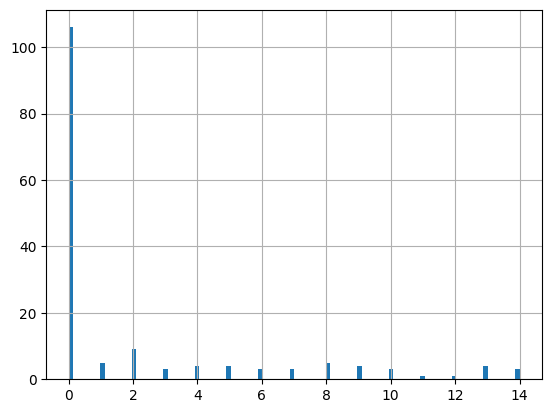

In [3]:
(mergedMappingDf.hospital_admission_next - mergedMappingDf.dischtime_adm).dt.days.hist(bins=100)

In [4]:
mergedMappingDf = mergedMappingDf[['person_id', 'visit_occurrence_id']].drop_duplicates()
mergedMappingDf['ICU_ADMISSION'] = True
mergedMappingDf

,person_id,visit_occurrence_id,ICU_ADMISSION
80,2091832,593291,True
340,2091832,625127,True
527,2229540,638765,True
536,2229540,639299,True
650,2161817,647732,True
...,...,...,...
23108,2680034,17495361,True
23177,2681377,17518169,True
23231,51211,17539195,True
23239,2123103,17542327,True


In [5]:
mergedMappingDf.shape[0]/dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape[0]*100

0.6731682057478208

### From master journey file

In [6]:
import pandas as pd


mergedJourneyDf = dataDf[['person_id', 'visit_occurrence_id', 'dischtime_adm']].drop_duplicates().merge(
    superbugJourneyDf[['PATIENT_ID', 'JOURNEY_ID', 'JOURNEY_START_DATETIME', 'JOURNEY_END_DATETIME', 'ICU_HOURS']].drop_duplicates().add_suffix('_next'),
    how='inner',
    left_on=['person_id'],
    right_on=['PATIENT_ID_next']
)
mergedJourneyDf.dischtime_adm = pd.to_datetime(mergedJourneyDf.dischtime_adm, format='%d/%m/%Y')
mergedJourneyDf.JOURNEY_START_DATETIME_next = pd.to_datetime(mergedJourneyDf.JOURNEY_START_DATETIME_next.str.split(' ').apply(lambda x: x[0]), format='%m/%d/%Y')
mergedJourneyDf.JOURNEY_END_DATETIME_next = pd.to_datetime(mergedJourneyDf.JOURNEY_END_DATETIME_next.str.split(' ').apply(lambda x: None if isinstance(x, float) else x[0]), format='%m/%d/%Y')
mergedJourneyDf = mergedJourneyDf[
    (
        ((mergedJourneyDf.dischtime_adm >= mergedJourneyDf.JOURNEY_START_DATETIME_next) & (mergedJourneyDf.dischtime_adm <= mergedJourneyDf.JOURNEY_END_DATETIME_next))
    |
        ((mergedJourneyDf.dischtime_adm <= mergedJourneyDf.JOURNEY_START_DATETIME_next) & (mergedJourneyDf.dischtime_adm >= (mergedJourneyDf.JOURNEY_START_DATETIME_next - pd.Timedelta(days=14))))
    )
    &
    (mergedJourneyDf.ICU_HOURS_next > 0)
]
mergedJourneyDf

,person_id,visit_occurrence_id,dischtime_adm,PATIENT_ID_next,JOURNEY_ID_next,JOURNEY_START_DATETIME_next,JOURNEY_END_DATETIME_next,ICU_HOURS_next
2411,2007132,547151,2018-07-11,2007132,571477,2018-07-20,2018-11-06,41.83
2667,310471,561279,2018-08-20,310471,561279,2018-06-21,2018-08-20,951.82
2714,2148368,567157,2018-11-22,2148368,567157,2018-07-09,2019-01-17,2079.42
2800,2141316,568642,2018-09-27,2141316,568642,2018-07-12,2018-10-15,1635.05
2802,2137981,568874,2018-07-25,2137981,568874,2018-07-12,2018-07-25,72.43
...,...,...,...,...,...,...,...,...
642285,2090730,17725075,2023-05-25,2090730,17725075,2023-05-18,2023-05-25,22.02
645630,2608730,17871735,2023-07-28,2608730,17080660,2022-11-08,2023-09-26,2155.12
648095,2488040,17912378,2023-07-18,2488040,17912378,2023-07-12,2023-07-18,50.23
650305,2608730,17968855,2023-07-28,2608730,17080660,2022-11-08,2023-09-26,2155.12


<Axes: >

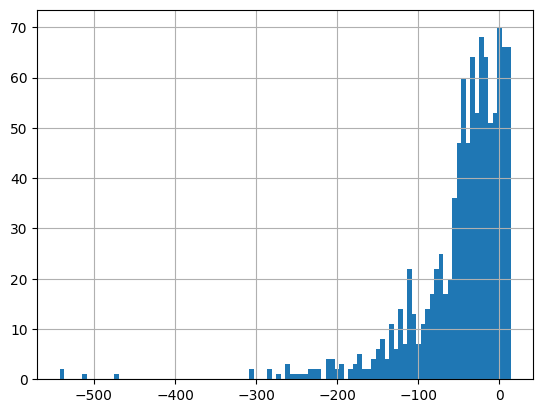

In [7]:
(mergedJourneyDf.JOURNEY_START_DATETIME_next - mergedJourneyDf.dischtime_adm).dt.days.hist(bins=100)

In [8]:
mergedJourneyDf = mergedJourneyDf[['person_id', 'visit_occurrence_id']].drop_duplicates()
mergedJourneyDf['ICU_ADMISSION'] = True
mergedJourneyDf

,person_id,visit_occurrence_id,ICU_ADMISSION
2411,2007132,547151,True
2667,310471,561279,True
2714,2148368,567157,True
2800,2141316,568642,True
2802,2137981,568874,True
...,...,...,...
642285,2090730,17725075,True
645630,2608730,17871735,True
648095,2488040,17912378,True
650305,2608730,17968855,True


In [9]:
mergedJourneyDf.shape[0]/dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape[0]*100

4.384223698972987

### From transfers file

In [10]:
mergedTransferDf = dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().merge(
    transferDf[['PATIENT_ID', 'EPISODE_ID', 'TO_WARD_CODE']].drop_duplicates(),
    how='inner',
    left_on=['person_id', 'visit_occurrence_id'],
    right_on=['PATIENT_ID', 'EPISODE_ID']
)
mergedTransferDf = mergedTransferDf[mergedTransferDf.TO_WARD_CODE.str.lower().str.contains('icu')]
mergedTransferDf

,person_id,visit_occurrence_id,PATIENT_ID,EPISODE_ID,TO_WARD_CODE
1,268318,338786,268318,338786,ICU
14,2008613,394685,2008613,394685,ICU
23,1005468,512166,1005468,512166,ICU
26,2136080,521377,2136080,521377,ICU
36,2159921,544741,2159921,544741,ICU
69,2155178,607616,2155178,607616,ICU
86,2158635,614074,2158635,614074,ICU
101,2167758,616735,2167758,616735,ICU
160,2177229,632009,2177229,632009,ICU
178,2091115,636472,2091115,636472,ICU


In [11]:
mergedTransferDf = mergedTransferDf[['person_id', 'visit_occurrence_id']].drop_duplicates()
mergedTransferDf['ICU_ADMISSION'] = True
mergedTransferDf

,person_id,visit_occurrence_id,ICU_ADMISSION
1,268318,338786,True
14,2008613,394685,True
23,1005468,512166,True
26,2136080,521377,True
36,2159921,544741,True
69,2155178,607616,True
86,2158635,614074,True
101,2167758,616735,True
160,2177229,632009,True
178,2091115,636472,True


In [12]:
mergedTransferDf.shape[0]/dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape[0]*100

0.14671614740657635

### From ICU Admission file

In [13]:
import pandas as pd


mergedIcuadmissionsDf = dataDf[['person_id', 'visit_occurrence_id', 'dischtime_adm']].drop_duplicates().merge(
    icuAdmissionsDf[['PATIENT_ID', 'EPISODE_ID', 'ADMIT_DATETIME']].drop_duplicates().add_suffix('_next'),
    how='inner',
    left_on=['person_id'],
    right_on=['PATIENT_ID_next']
)
mergedIcuadmissionsDf.dischtime_adm = pd.to_datetime(mergedIcuadmissionsDf.dischtime_adm, format='%d/%m/%Y')
mergedIcuadmissionsDf.ADMIT_DATETIME_next = pd.to_datetime(mergedIcuadmissionsDf.ADMIT_DATETIME_next.str.split(' ').apply(lambda x: None if isinstance(x, float) else x[0]), format='%Y-%m-%d')
mergedIcuadmissionsDf = mergedIcuadmissionsDf[
    (
        (mergedIcuadmissionsDf.visit_occurrence_id != mergedIcuadmissionsDf.EPISODE_ID_next)
        &
        (mergedIcuadmissionsDf.dischtime_adm <= mergedIcuadmissionsDf.ADMIT_DATETIME_next)
        &
        (mergedIcuadmissionsDf.dischtime_adm >= (mergedIcuadmissionsDf.ADMIT_DATETIME_next - pd.Timedelta(days=14)))
    )
]
mergedIcuadmissionsDf

,person_id,visit_occurrence_id,dischtime_adm,PATIENT_ID_next,EPISODE_ID_next,ADMIT_DATETIME_next
5,2152832,113016,2014-12-30,2152832,113784,2015-01-05
58,2108948,249556,2015-09-08,2108948,168964,2015-09-10
231,652907,432989,2017-07-04,652907,442087,2017-07-15
244,652907,438313,2017-07-14,652907,442087,2017-07-15
259,2195604,443701,2017-08-27,2195604,458626,2017-09-10
...,...,...,...,...,...,...
20199,2514680,17883870,2023-07-04,2514680,17884461,2023-07-04
20293,469903,17963944,2023-07-27,469903,17966097,2023-07-27
20295,2225152,17966781,2023-08-14,2225152,18026406,2023-08-14
20337,2193278,18009587,2023-08-09,2193278,18011805,2023-08-09


In [14]:
mergedIcuadmissionsDf = mergedIcuadmissionsDf[['person_id', 'visit_occurrence_id']].drop_duplicates()
mergedIcuadmissionsDf['ICU_ADMISSION'] = True
mergedIcuadmissionsDf

,person_id,visit_occurrence_id,ICU_ADMISSION
5,2152832,113016,True
58,2108948,249556,True
231,652907,432989,True
244,652907,438313,True
259,2195604,443701,True
...,...,...,...
20199,2514680,17883870,True
20293,469903,17963944,True
20295,2225152,17966781,True
20337,2193278,18009587,True


In [15]:
mergedIcuadmissionsDf.shape[0]/dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape[0]*100

5.570898420643825

## Combine all the information

In [16]:
mergedMappingDf.shape, mergedJourneyDf.shape, mergedTransferDf.shape, mergedIcuadmissionsDf.shape

((156, 3), (1016, 3), (34, 3), (1291, 3))

In [17]:
combinedDf = pd.concat([mergedMappingDf, mergedJourneyDf, mergedTransferDf, mergedIcuadmissionsDf], ignore_index=True).drop_duplicates()
combinedDf

,person_id,visit_occurrence_id,ICU_ADMISSION
0,2091832,593291,True
1,2091832,625127,True
2,2229540,638765,True
3,2229540,639299,True
4,2161817,647732,True
...,...,...,...
2492,2514680,17883870,True
2493,469903,17963944,True
2494,2225152,17966781,True
2495,2193278,18009587,True


In [18]:
combinedDf.shape[0]/dataDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape[0]*100

9.441615603693796

## Explore ICU Admission labels

In [19]:
combinedDf

,person_id,visit_occurrence_id,ICU_ADMISSION
0,2091832,593291,True
1,2091832,625127,True
2,2229540,638765,True
3,2229540,639299,True
4,2161817,647732,True
...,...,...,...
2492,2514680,17883870,True
2493,469903,17963944,True
2494,2225152,17966781,True
2495,2193278,18009587,True


In [22]:
icuAdmissionsDf

,ICU_ADMISSION_ID,PARENT_EPISODE_ID,PATIENT_ID,EPISODE_ID,REFERRAL_DATETIME,REFERRAL_ACTION_DATETIME,REFERRAL_ORDER_ID,ADMIT_DATETIME,ADMISSION_SOURCE,HOSPITAL_ADMISSION_SOURCE,...,LAST_UPDATED_BY_PROVIDER_INT_ID,LAST_UPDATE_DATETIME,RECORD_STATUS,ORIGINATING_SYSTEM,ORIGINATING_SYSTEM_PK,CREATED_BY,MODIFIED_BY,CREATED_DATETIME,MODIFIED_DATETIME,SUPPRESSED
0,8,338686,2121884,338686,NaN,NaN,NaN,2016-11-01 00:45:00.000,OT / RECOVERY,Home,...,752991,2017-02-01 16:56:00,A,Cerner,11442,LINKEN,LINKEN,2023-09-18 16:28:57.820,2024-02-07 10:37:57.327,0
1,24,354273,316516,354273,NaN,NaN,NaN,2016-11-03 00:05:00.000,OT / RECOVERY,Home,...,743892,2017-07-14 14:10:54,A,Cerner,11458,SYSTEM,SYSTEM,2023-09-18 16:28:57.820,2024-02-07 10:37:57.327,0
2,33,350242,2099069,350242,NaN,NaN,NaN,2016-11-04 01:53:00.000,WARD,Home,...,752991,2017-02-01 12:10:22,A,Cerner,11467,LINKEN,LINKEN,2023-09-18 16:28:57.820,2024-02-07 10:37:57.327,0
3,43,355223,1001248,355223,NaN,NaN,NaN,2016-11-05 12:33:00.000,OT / RECOVERY,Home,...,752991,2017-02-01 16:36:42,A,Cerner,11477,LINKEN,LINKEN,2023-09-18 16:28:57.820,2024-02-07 10:37:57.327,0
4,67,332295,652290,332295,NaN,NaN,NaN,2016-11-09 10:13:00.000,WARD,Other Hospital - ICU,...,752991,2017-02-02 15:52:55,A,Cerner,11501,LINKEN,LINKEN,2023-09-18 16:28:57.820,2024-02-07 10:37:57.327,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806,29319,18567602,2131388,18567602,NaN,NaN,NaN,2024-01-23 22:42:00.000,OT / RECOVERY,Home,...,830378,2024-02-15 14:36:32,A,Cerner,37790,SYSTEM,MALLERL,2024-01-23 22:48:51.250,2024-02-15 14:56:33.550,0
3807,29366,18580467,2162592,18580839,2024-01-28 14:13:44.000,2024-01-28 14:14:21.000,96069325.0,2024-01-28 19:49:00.000,EMERGENCY,Home,...,830378,2024-02-14 08:00:30,A,Cerner,37818,SYSTEM,MALLERL,2024-01-28 19:59:08.687,2024-02-14 08:16:53.040,0
3808,29382,18584202,2196022,18586220,2024-01-29 19:16:53.000,2024-01-29 19:18:12.000,96111538.0,2024-01-30 02:13:00.000,EMERGENCY,Other Acute Hospital (not ICU/ED),...,830378,2024-02-06 11:36:56,A,Cerner,37837,SYSTEM,MALLERL,2024-01-30 04:24:48.603,2024-02-07 10:37:57.327,0
3809,29441,18606263,2045525,18606593,NaN,NaN,NaN,2024-02-04 06:15:00.000,WARD,Home,...,832714,2024-02-15 15:52:58,A,Cerner,37900,SYSTEM,COLLINSKAT,2024-02-04 06:50:10.170,2024-02-15 16:15:41.600,0


In [21]:
icuAdmissionsDf.columns

Index(['ICU_ADMISSION_ID', 'PARENT_EPISODE_ID', 'PATIENT_ID', 'EPISODE_ID',
       'REFERRAL_DATETIME', 'REFERRAL_ACTION_DATETIME', 'REFERRAL_ORDER_ID',
       'ADMIT_DATETIME', 'ADMISSION_SOURCE', 'HOSPITAL_ADMISSION_SOURCE',
       'HOSPITAL_ADMISSION_DATETIME', 'HOSPITAL_DISCHARGE_DATETIME',
       'EMERGENCY_RESPONSE_ADMISSION', 'VISIT_SEQUENCE', 'AGE_AT_ADMISSION',
       'PATIENT_TYPE', 'PATIENT_POSTCODE', 'PATIENT_INDIGENOUS_STATUS',
       'HEIGHT', 'WEIGHT', 'REFERRAL_OUTCOME', 'REFERRAL_OUTCOME_REASON',
       'DIAGNOSIS', 'DIAGNOSIS_CVID', 'APACHE_SYSTEM', 'APACHE_CODE',
       'APACHE_SUBCODE', 'CARDIAC_ARREST_IN_PREVIOUS_24HOURS',
       'RESPIRATORY_ARREST_IN_PREVIOUS_24HOURS', 'DISCHARGE_READINESS',
       'DISCHARGE_DECISION_DATETIME', 'IS_READY_TO_GO', 'READY_SINCE_DATETIME',
       'DISCHARGE_DATETIME', 'POD', 'BED_TYPE', 'BED', 'BED_CODE', 'SPECIALTY',
       'SPECIALTY_CODE', 'TREATMENT_LIMITATION', 'IS_ELECTIVE_ADMISSION',
       'IS_ELECTIVE_SURGERY', 'IS_PLANNED'

In [25]:
icuAdmissionsDf.merge(
    combinedDf,
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).ADMISSION_SOURCE.value_counts()

ADMISSION_SOURCE
WARD                  238
OT / RECOVERY         198
OTHER HOSPITAL ICU    105
OTHER HOSPITAL         23
EMERGENCY              17
Name: count, dtype: int64